# Gate based workflow

This notebook shows an example of how a gate based computation (in this case using `qiskit`) could be integrated into `qse`.

In [15]:
import qse
import numpy as np
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.circuit import QuantumCircuit

## Step 1: Create qbits object

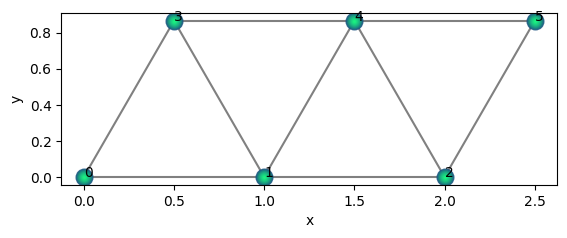

In [16]:
h = np.sqrt(1 - 0.5*0.5)

positions = np.array([
    [0., 0., 0.],
    [1., 0., 0.],
    [2., 0., 0.],
    [0.5, h, 0.],
    [1.5, h, 0.],
    [2.5, h, 0.],
    ])

qbits = qse.Qbits(positions=positions)
qbits.draw(show_labels=True, radius="nearest")

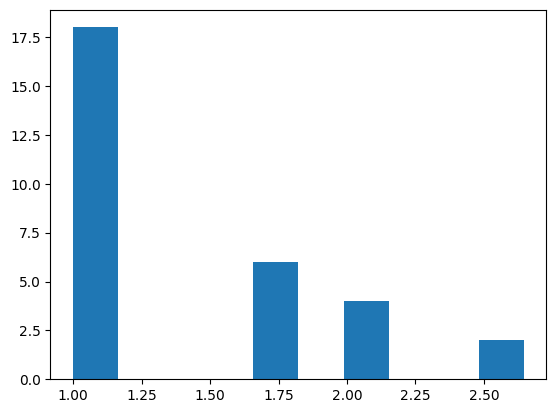

In [19]:
plt.hist([i for i in qbits.get_all_distances().flatten() if i > 0.01])
plt.show()

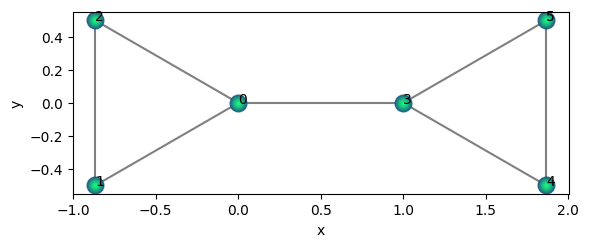

In [30]:
h = np.sqrt(1 - 0.5*0.5)

positions = np.array([
    [0., 0., 0.],
    [-h, -0.5, 0.],
    [-h, 0.5, 0.],
    [1., 0., 0.],
    [1+h, -0.5, 0.],
    [1+h, 0.5, 0.],
    ])

qbits = qse.Qbits(positions=positions)
qbits.draw(show_labels=True, radius="nearest")

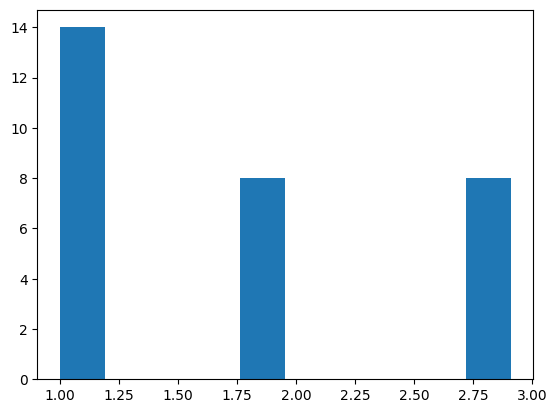

In [31]:
plt.hist([i for i in qbits.get_all_distances().flatten() if i > 0.01])
plt.show()

# Step 2: Define a distance function to create an interaction Hamiltonian that's based on the geometry of the qubits.

In [32]:
def distance_func(distance, tolerance=0.01):
    """
    Simple distance function that only includes nearest neighbours.
    
    This function returns a coefficient of 1.0 if the input distance is approximately 1.0
    (within a specified tolerance), otherwise it returns 0.0.
    """
    if np.abs(distance-1) < tolerance:
        return 1.
    return 0.

In [33]:
# simple ZZ coupling
coupling = qbits.compute_interaction_hamiltonian(distance_func, "Z")
coupling
# We can easily do something more complicated like a Heisenberg model:
# coupling = 
# qbits.compute_interaction_hamiltonian(distance_func, "X") + 
# qbits.compute_interaction_hamiltonian(distance_func, "Y") + 
# qbits.compute_interaction_hamiltonian(distance_func, "Z")


[1.00 Z0 Z1,
 1.00 Z0 Z2,
 1.00 Z0 Z3,
 1.00 Z1 Z2,
 1.00 Z3 Z4,
 1.00 Z3 Z5,
 1.00 Z4 Z5]

In [34]:
ext_field = [qse.Operator("X", i, 1.0, qbits.nqbits) for i in range(qbits.nqbits)]
ext_field

[1.00 X0, 1.00 X1, 1.00 X2, 1.00 X3, 1.00 X4, 1.00 X5]

In [35]:
hamiltonian = coupling + ext_field
hamiltonian

[1.00 Z0 Z1,
 1.00 Z0 Z2,
 1.00 Z0 Z3,
 1.00 Z1 Z2,
 1.00 Z3 Z4,
 1.00 Z3 Z5,
 1.00 Z4 Z5,
 1.00 X0,
 1.00 X1,
 1.00 X2,
 1.00 X3,
 1.00 X4,
 1.00 X5]

## Step 3: Run in qiskit
Here we use a simple VQE workflow.

In [36]:
hamiltonian_qiskit = SparsePauliOp([i.to_str() for i in hamiltonian], [i.coef for i in hamiltonian])
print(hamiltonian_qiskit)
ansatz = efficient_su2(qbits.nqbits, reps=1)

SparsePauliOp(['ZZIIII', 'ZIZIII', 'ZIIZII', 'IZZIII', 'IIIZZI', 'IIIZIZ', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [37]:
def compute_expectation(params):
    """Compute the expectation value of a quantum operator using a statevector simulator."""
    estimator = StatevectorEstimator()

    pub = (ansatz, hamiltonian_qiskit, params)
    job = estimator.run([pub])

    return job.result()[0].data.evs

def run_sampler(params, shots=1000):
    """Sample a circuit using a statevector simulator."""
    sampler = StatevectorSampler()

    circuit = QuantumCircuit(ansatz.num_qubits)
    circuit.append(ansatz, range(ansatz.num_qubits))
    circuit.measure_all()

    pub = (circuit, params)
    job = sampler.run([pub], shots=shots)

    return job.result()[0].data.meas.get_counts()

In [38]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

cost_hist = []
opt_result = minimize(
    compute_expectation, x0, method="BFGS", 
    callback=lambda intermediate_result: cost_hist.append(intermediate_result.fun)
    )
opt_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -6.839109873659719
        x: [ 2.817e+00  1.829e-01 ...  2.883e+00  7.040e+00]
      nit: 130
      jac: [-6.557e-07  1.311e-06 ...  3.278e-06  5.245e-06]
 hess_inv: [[ 4.449e-01  8.411e-02 ... -9.078e-03 -4.828e-02]
            [ 8.411e-02  4.946e-01 ... -5.601e-02  2.424e-01]
            ...
            [-9.078e-03 -5.601e-02 ...  7.439e+01 -2.515e+01]
            [-4.828e-02  2.424e-01 ... -2.515e+01  3.082e+02]]
     nfev: 3600
     njev: 144

In [39]:
samples = run_sampler(opt_result.x, shots=1000)
samples

{'101001': 49,
 '100011': 124,
 '110011': 79,
 '101010': 76,
 '110001': 66,
 '010101': 10,
 '111111': 4,
 '110010': 72,
 '010011': 25,
 '100101': 13,
 '100110': 8,
 '100010': 80,
 '010010': 17,
 '101011': 88,
 '100001': 72,
 '101100': 4,
 '010001': 17,
 '001010': 3,
 '111010': 10,
 '111001': 10,
 '111101': 6,
 '110000': 12,
 '000011': 10,
 '111011': 15,
 '110111': 10,
 '001001': 7,
 '100111': 3,
 '111110': 1,
 '110110': 4,
 '101110': 6,
 '001011': 8,
 '110101': 16,
 '100000': 11,
 '010000': 4,
 '101101': 15,
 '011010': 2,
 '000001': 1,
 '101000': 8,
 '011000': 1,
 '000010': 5,
 '101111': 6,
 '011001': 2,
 '100100': 4,
 '010110': 1,
 '011011': 3,
 '110100': 4,
 '000101': 2,
 '001000': 1,
 '001101': 1,
 '001111': 1,
 '111000': 2,
 '000000': 1}

In [40]:
samples_top = {i:j for i,j in samples.items() if j > 50}
samples_top

{'100011': 124,
 '110011': 79,
 '101010': 76,
 '110001': 66,
 '110010': 72,
 '100010': 80,
 '101011': 88,
 '100001': 72}

## Step 4: Visualize results in qse

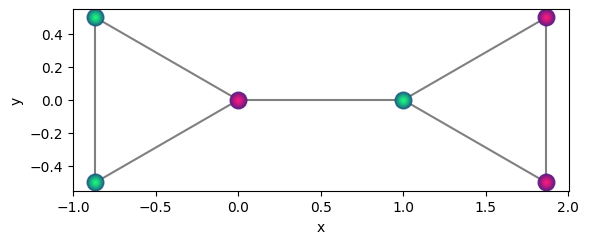

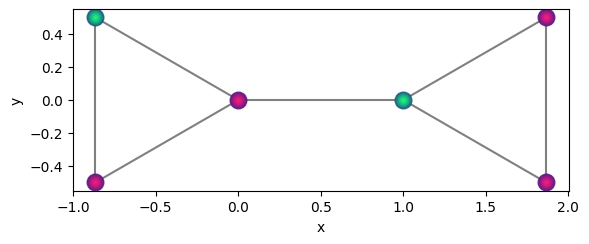

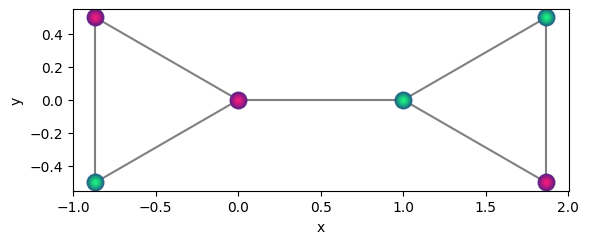

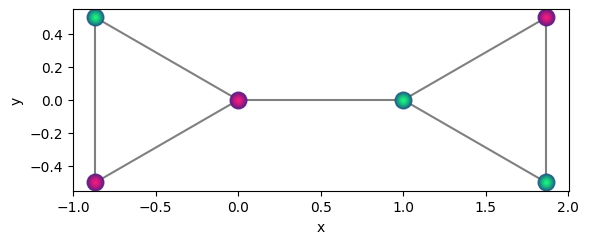

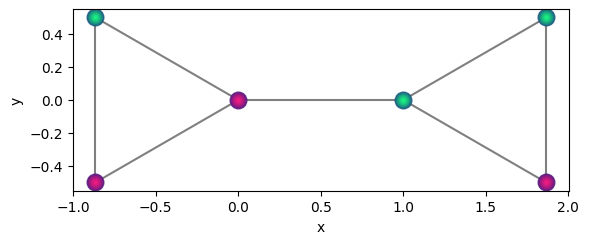

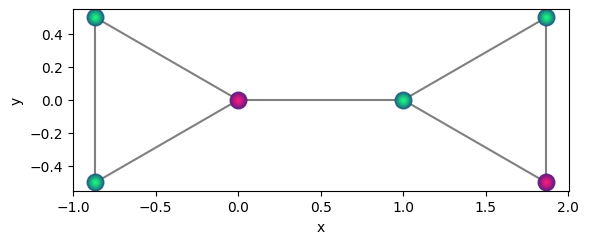

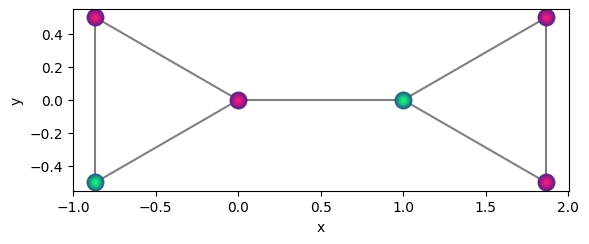

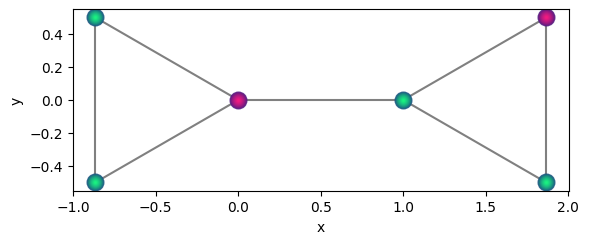

In [41]:
for s in samples_top.keys():
    qbits.draw(colouring=s, radius="nearest")